In [250]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn import preprocessing, tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus 
from sklearn import metrics
from IPython.display import Image 

# Decision tree > Getting FUND

In [251]:
df=pd.read_json('../01_Preprocessing/First.json').sort_index()

In [252]:
df.head(10)

,country,countryCoded,degree,degreeCoded,eng,engCoded,fieldGroup,fund,gpaBachelors,gpaMasters,gre,highLevelBachUni,highLevelMasterUni,paper,targetUni,uniRank,year
2,united kingdom,4,Doctorate,1,High,1,7,TRUE,3.500000,3.442986,FALSE,FALSE,FALSE,6.666667,heriot-watt,692.0,2007
3,united states,0,Doctorate,1,VeryHigh,0,5,TRUE,2.500000,3.500000,TRUE,TRUE,FALSE,11.333333,northwestern,20.0,2010
5,united states,0,Doctorate,1,VeryHigh,0,10,TRUE,3.500000,4.000000,TRUE,TRUE,TRUE,5.333333,cornell,11.0,2008
6,sweden,2,Masters,0,High,1,0,FALSE,3.000000,3.442986,TRUE,TRUE,FALSE,0.000000,chalmers,443.0,2008
7,spain,3,Masters,0,VeryHigh,0,10,TRUE,2.611309,3.442986,FALSE,FALSE,FALSE,0.000000,carlos iii de madrid,NaN,2008
8,australia,1,Masters,0,Medium,2,10,FALSE,3.000000,2.500000,FALSE,TRUE,TRUE,0.000000,adelaide,318.0,2009
9,united states,0,Masters,0,VeryHigh,0,0,TRUE,3.500000,3.500000,FALSE,TRUE,FALSE,1.000000,"new york , abu dhabi",21.0,2008
10,canada,0,Doctorate,1,High,1,11,TRUE,3.000000,4.000000,TRUE,TRUE,TRUE,11.333333,mcmaster,134.0,2008
12,united states,0,Masters,0,High,1,0,TRUE,3.500000,3.000000,TRUE,FALSE,FALSE,0.666667,tallinn,NaN,2007
13,canada,0,Doctorate,1,VeryHigh,0,0,TRUE,2.500000,3.000000,TRUE,TRUE,TRUE,0.333333,calgary,172.0,2008


In [253]:
df.columns

Index([u'country', u'countryCoded', u'degree', u'degreeCoded', u'eng',
       u'engCoded', u'fieldGroup', u'fund', u'gpaBachelors', u'gpaMasters',
       u'gre', u'highLevelBachUni', u'highLevelMasterUni', u'paper',
       u'targetUni', u'uniRank', u'year'],
      dtype='object')

In [254]:
df.uniRank.fillna(294,inplace=True)

In [255]:
df.fund= df.fund=='TRUE'
df.gre= df.gre=='TRUE'
df.highLevelBachUni= df.highLevelBachUni=='TRUE'
df.highLevelMasterUni= df.highLevelMasterUni=='TRUE'

# Rules

In [256]:
#help : https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print node

In [257]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)

In [258]:
df[df.engCoded==-1]

,country,countryCoded,degree,degreeCoded,eng,engCoded,fieldGroup,fund,gpaBachelors,gpaMasters,gre,highLevelBachUni,highLevelMasterUni,paper,targetUni,uniRank,year


# DTree Fund For PHD Students

In [259]:
col=['countryCoded', 'engCoded', 'fieldGroup', 'gpaBachelors','gpaMasters', 'gre', 
     'highLevelBachUni', 'highLevelMasterUni','paper','uniRank']
data=df[df.degreeCoded==1][col]
target=df[df.degreeCoded==1].fund
xtr,xte,ytr,yte=train_test_split(data,target,test_size=0.2,random_state=99)

In [260]:
data.head()

,countryCoded,engCoded,fieldGroup,gpaBachelors,gpaMasters,gre,highLevelBachUni,highLevelMasterUni,paper,uniRank
2,4,1,7,3.5,3.442986,False,False,False,6.666667,692.0
3,0,0,5,2.5,3.500000,True,True,False,11.333333,20.0
5,0,0,10,3.5,4.000000,True,True,True,5.333333,11.0
10,0,1,11,3.0,4.000000,True,True,True,11.333333,134.0
13,0,0,0,2.5,3.000000,True,True,True,0.333333,172.0


In [261]:
print(xtr.shape,ytr.shape,xte.shape,yte.shape)

((1418, 10), (1418L,), (355, 10), (355L,))


In [262]:
def build3(xtr, ytr,xte,yte,rocEnable,max_depth,criterion='entropy',class_weight=None):
    clf = DecisionTreeClassifier(criterion = criterion, random_state = 100, max_depth=max_depth,class_weight=class_weight)
    clf.fit(xtr, ytr)
    ypred = clf.predict(xte)
    if rocEnable==False:
        acc=accuracy_score(yte,ypred)*100
    else:
        fpr, tpr, thresholds = metrics.roc_curve(yte,ypred)
        acc=metrics.auc(fpr, tpr)*100
    return (clf,acc,criterion)

In [263]:
bestAcc2,bestAcc,depth,depth2,gini,gini2=0,0,0,0,0,0
for i in range(3,10):
    clff,acc,criterion=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion='entropy',class_weight="balanced")
    if acc>bestAcc:
        bestAcc=acc;clf=clff;depth=i;gini=criterion
    
    clff,acc2,criterion=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion='entropy')
    if acc2>bestAcc2:
        bestAcc2=acc2;clf2=clf_entropy;depth2=i;gini2=criterion
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=i)
#     ,class_weight="balanced"
    clf_gini.fit(xtr, ytr)
    ypred = clf_gini.predict(xte)
    acc=accuracy_score(yte,ypred)*100
    if acc>bestAcc:
        bestAcc=acc;clf=clf_gini;depth=i;gini=1
    fpr, tpr, thresholds = metrics.roc_curve(yte,ypred)
    acc2=metrics.auc(fpr, tpr)*100
    if acc2>bestAcc2:
        bestAcc2=acc2;clf2=clf_gini;depth2=i;gini2=1

In [264]:
print(bestAcc,depth,gini)

(80.563380281690144, 4, 1)


In [265]:
print(bestAcc2,depth2,gini2)

(59.106301531213191, 3, 'entropy')


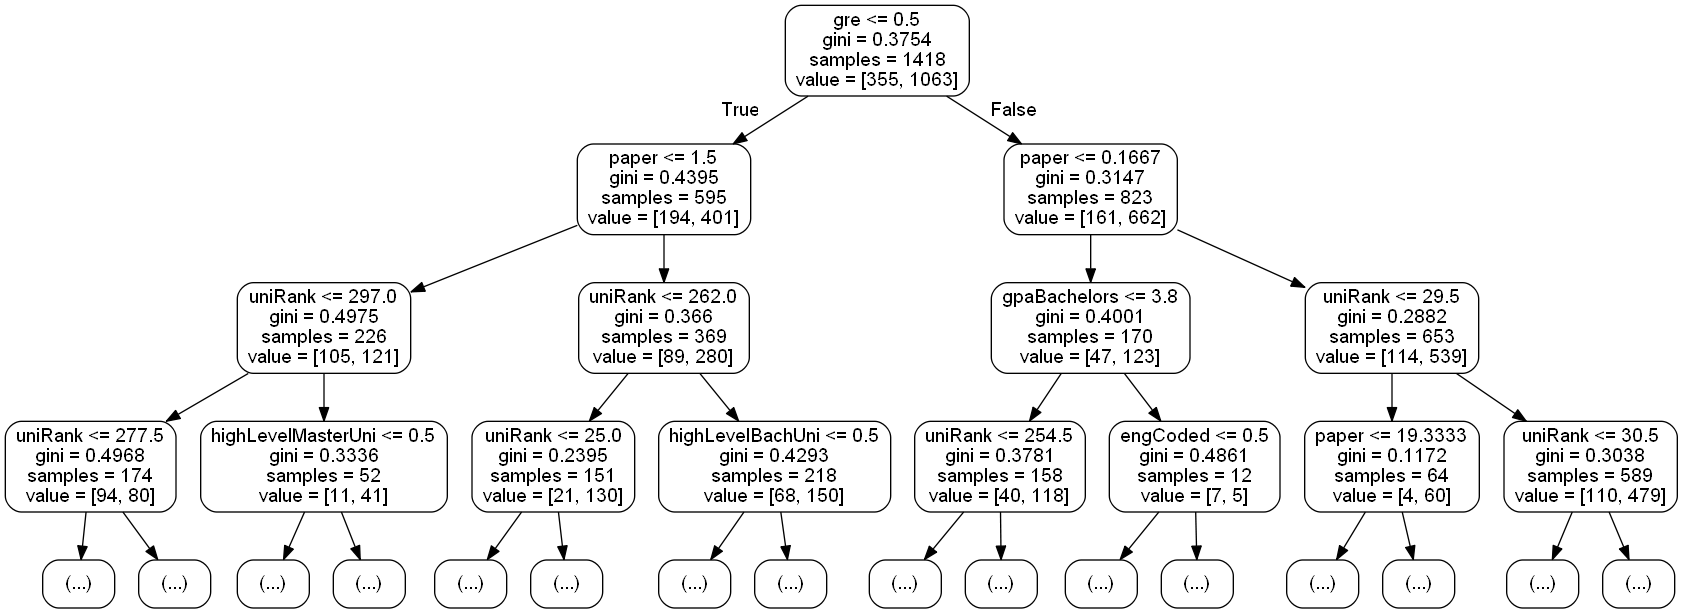

In [266]:
dot_data = tree.export_graphviz(clf, out_file=None,max_depth=3,feature_names=col,rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

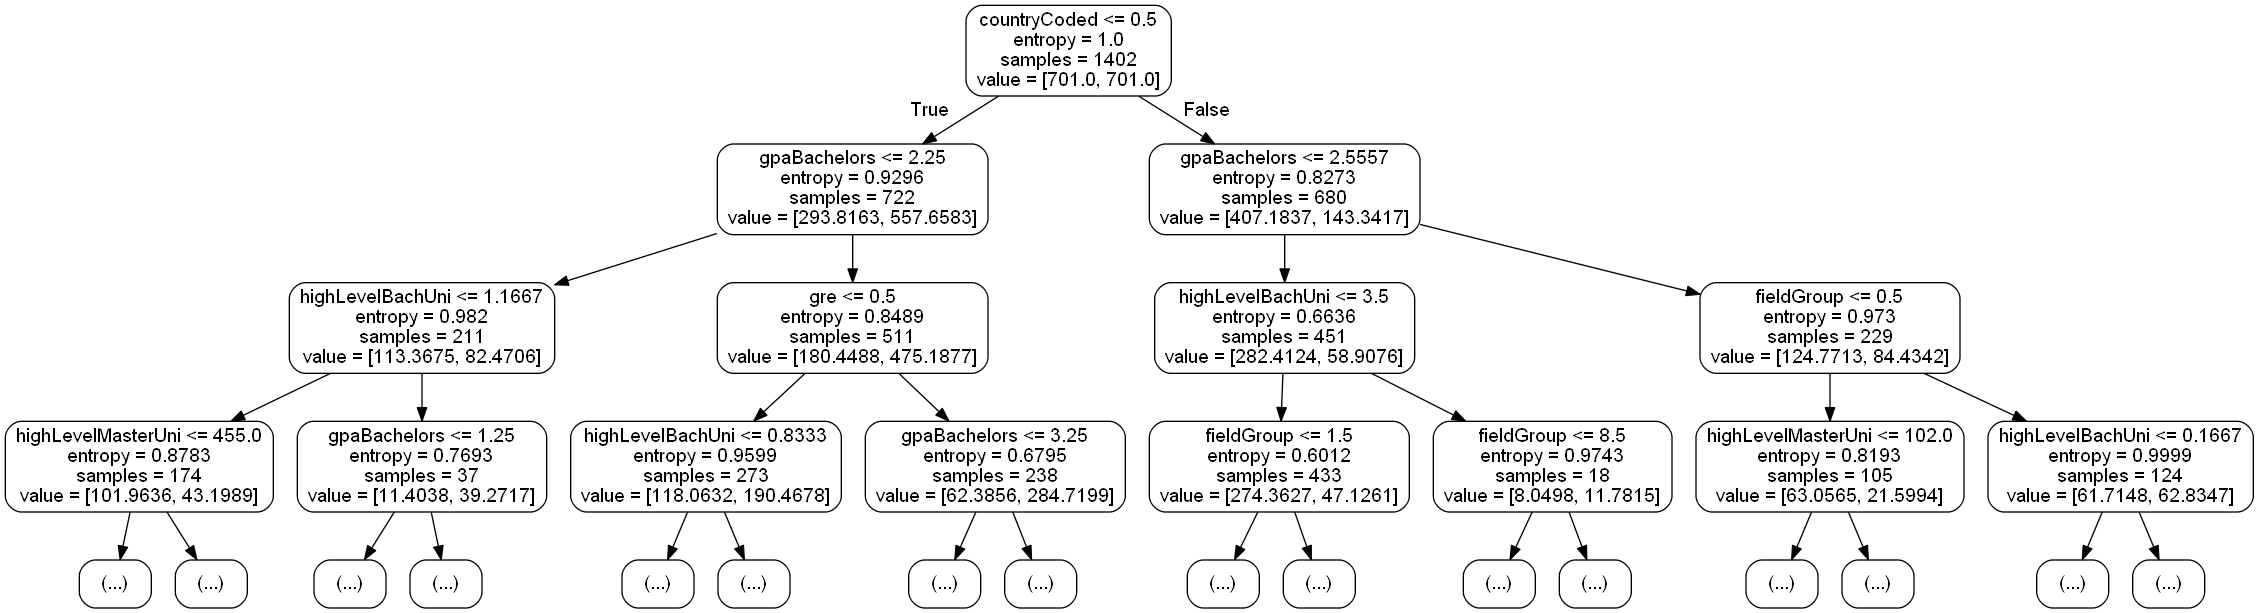

In [267]:
# AUC Tree
dot_data = tree.export_graphviz(clf2, out_file=None,max_depth=3,feature_names=col,rounded=True)  
# , proportion=True
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [268]:
get_code(clf,col)

if ( gre <= 0.5 ) {
if ( paper <= 1.5 ) {
if ( uniRank <= 297.0 ) {
if ( uniRank <= 277.5 ) {
return [[ 23.  43.]]
} else {
return [[ 71.  37.]]
}
} else {
if ( highLevelMasterUni <= 0.5 ) {
return [[ 10.  17.]]
} else {
return [[  1.  24.]]
}
}
} else {
if ( uniRank <= 262.0 ) {
if ( uniRank <= 25.0 ) {
return [[ 7.  6.]]
} else {
return [[  14.  124.]]
}
} else {
if ( highLevelBachUni <= 0.5 ) {
return [[ 55.  84.]]
} else {
return [[ 13.  66.]]
}
}
}
} else {
if ( paper <= 0.166666671634 ) {
if ( gpaBachelors <= 3.79999995232 ) {
if ( uniRank <= 254.5 ) {
return [[ 10.  59.]]
} else {
return [[ 30.  59.]]
}
} else {
if ( engCoded <= 0.5 ) {
return [[ 3.  5.]]
} else {
return [[ 4.  0.]]
}
}
} else {
if ( uniRank <= 29.5 ) {
if ( paper <= 19.3333320618 ) {
return [[  3.  60.]]
} else {
return [[ 1.  0.]]
}
} else {
if ( uniRank <= 30.5 ) {
return [[ 1.  0.]]
} else {
return [[ 109.  479.]]
}
}
}
}


In [269]:
get_code(clf2,col)

if ( countryCoded <= 0.5 ) {
if ( gpaBachelors <= 2.25 ) {
if ( highLevelBachUni <= 1.16666674614 ) {
if ( highLevelMasterUni <= 455.0 ) {
if ( engCoded <= 0.5 ) {
if ( gre <= 0.5 ) {
return [[ 5.36650718  0.        ]]
} else {
if ( gpaBachelors <= 1.75 ) {
return [[ 0.         5.8907563]]
} else {
if ( gpaMasters <= 0.5 ) {
return [[ 4.02488038  0.        ]]
} else {
if ( fieldGroup <= 3.0 ) {
return [[ 1.34162679  1.96358543]]
} else {
return [[ 0.          1.96358543]]
}
}
}
}
} else {
if ( highLevelBachUni <= 0.166666671634 ) {
if ( highLevelMasterUni <= 236.0 ) {
if ( highLevelMasterUni <= 200.0 ) {
return [[ 11.40382775   0.        ]]
} else {
if ( gpaBachelors <= 1.25 ) {
return [[ 0.6708134  0.       ]]
} else {
return [[ 0.6708134  5.8907563]]
}
}
} else {
if ( fieldGroup <= 9.5 ) {
return [[ 33.54066986   0.        ]]
} else {
if ( gpaBachelors <= 1.75 ) {
return [[ 8.04976077  1.96358543]]
} else {
return [[ 7.37894737  0.        ]]
}
}
}
} else {
if ( highLevelBachUni <= 0.

# For Masters Students

In [270]:
col=['countryCoded', 'engCoded', 'fieldGroup', 'gpaBachelors', 'gre', 'highLevelBachUni','paper','uniRank']
xtr,xte,ytr,yte=train_test_split(df[df.degreeCoded==0][col],df[df.degreeCoded==0].fund,test_size=0.2,random_state=99)

bestAcc2,bestAcc,depth,depth2,gini,gini2=0,0,0,0,0,0
for i in range(3,10):
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=i,class_weight="balanced")
    clf_entropy.fit(xtr, ytr)
    ypred = clf_entropy.predict(xte)
    acc=accuracy_score(yte,ypred)*100
    if acc>bestAcc:
        bestAcc=acc;clf=clf_entropy;depth=i;gini=0
    fpr, tpr, thresholds = metrics.roc_curve(yte,ypred)
    acc2=metrics.auc(fpr, tpr)*100
    if acc2>bestAcc2:
        bestAcc2=acc2;clf2=clf_entropy;depth2=i;gini2=0
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=i,class_weight="balanced")
    clf_gini.fit(xtr, ytr)
    ypred = clf_gini.predict(xte)
    acc=accuracy_score(yte,ypred)*100
    if acc>bestAcc:
        bestAcc=acc;clf=clf_gini;depth=i;gini=1
    fpr, tpr, thresholds = metrics.roc_curve(yte,ypred)
    acc2=metrics.auc(fpr, tpr)*100
    if acc2>bestAcc2:
        bestAcc2=acc2;clf2=clf_gini;depth2=i;gini2=1

In [271]:
print(bestAcc,depth,gini)

(77.492877492877483, 9, 0)


In [272]:
print(bestAcc2,depth2,gini2)

(74.367536488279526, 7, 0)


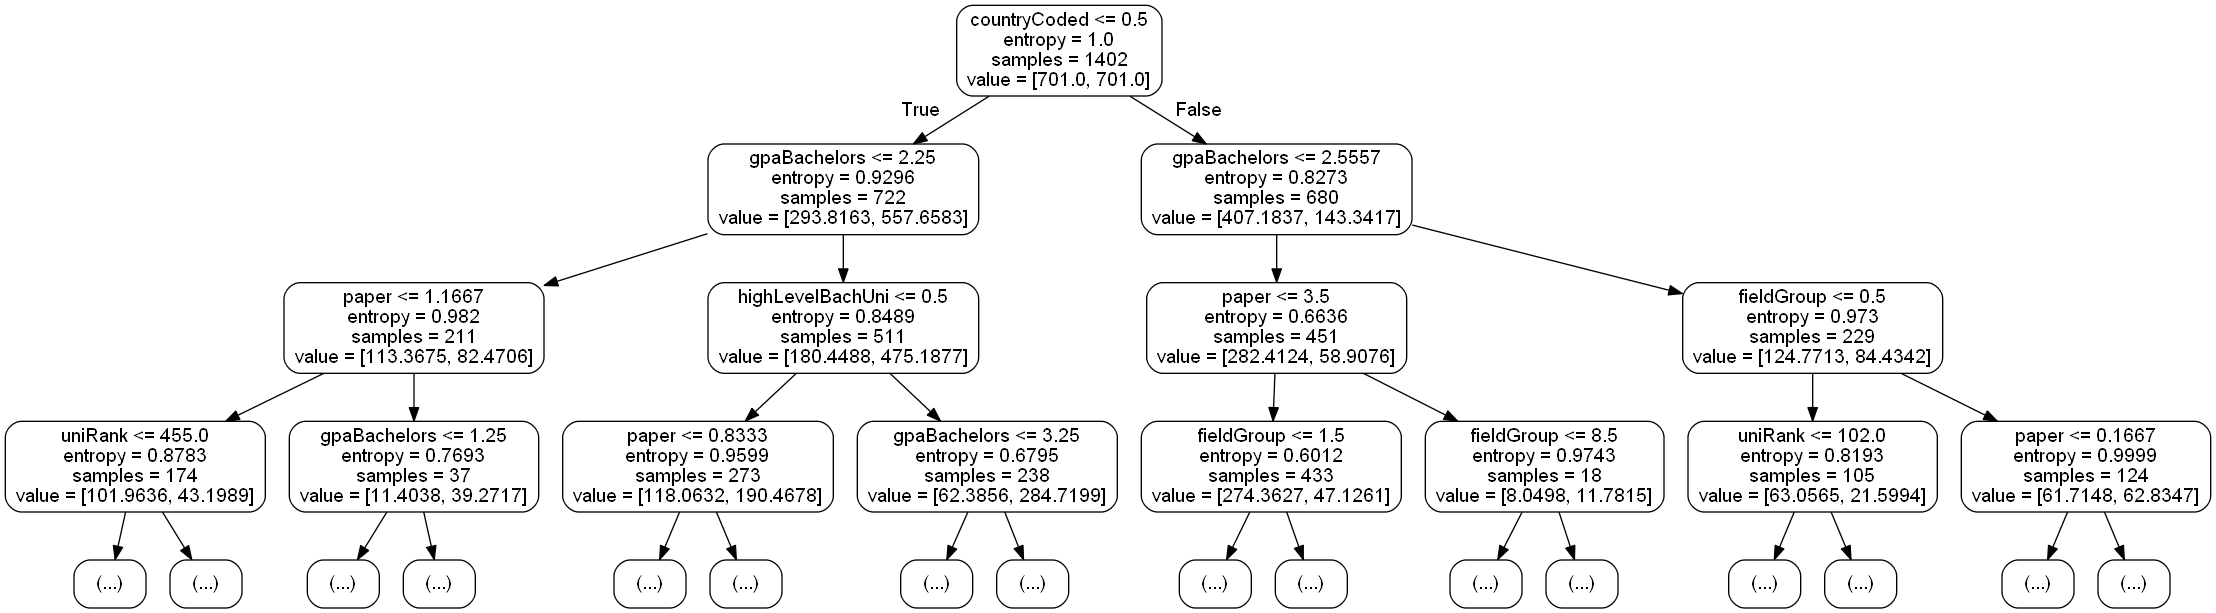

In [273]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=col,  max_depth=3, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

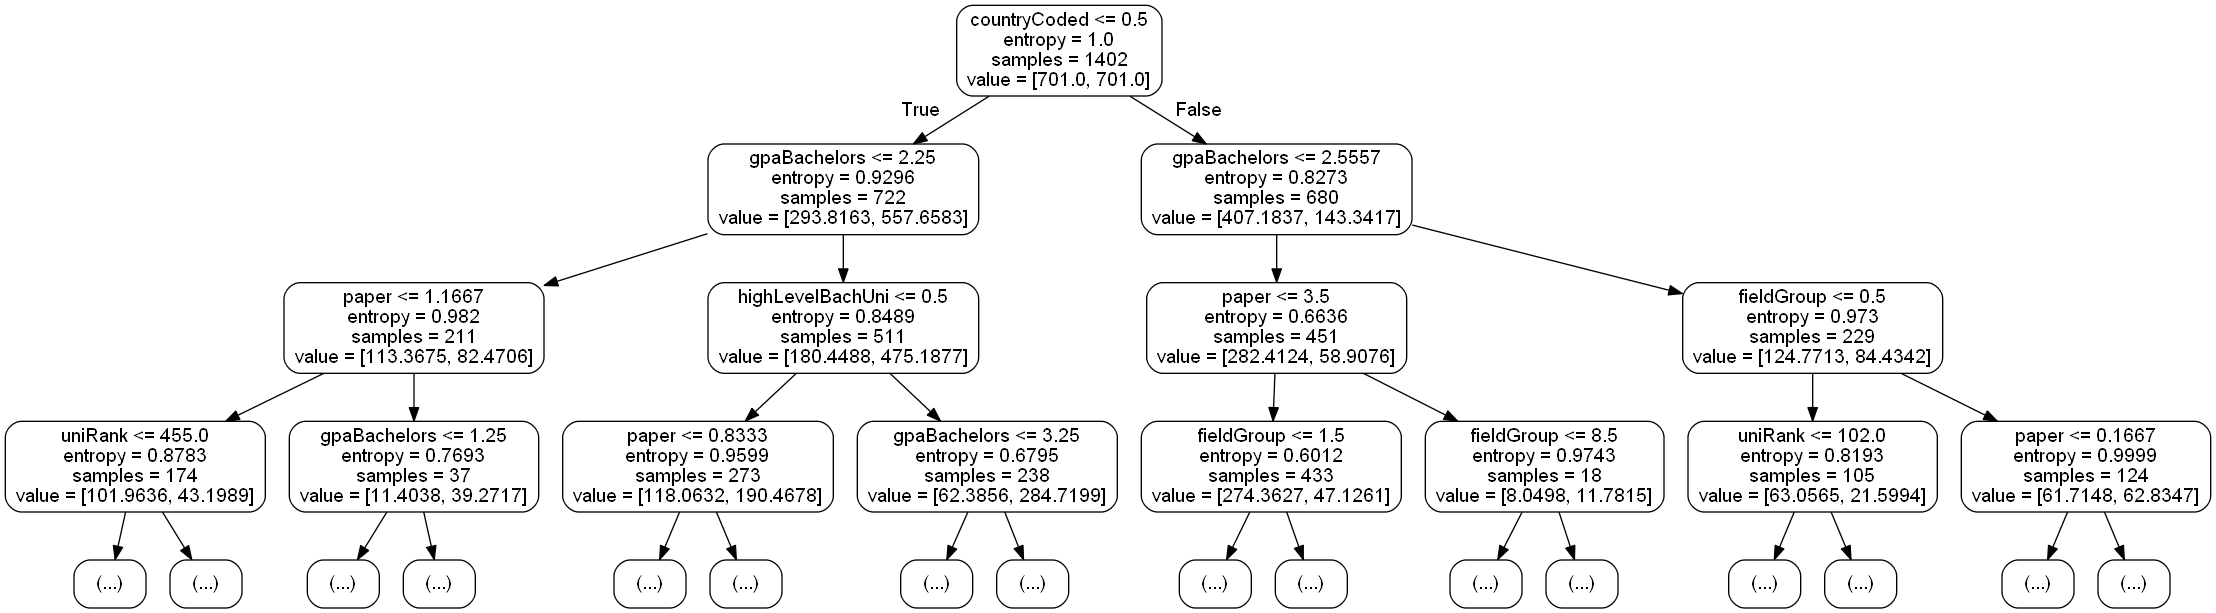

In [274]:
dot_data = tree.export_graphviz(clf2, out_file=None, feature_names=col,  max_depth=3, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

## Sample Path

In [275]:
# col=['countryCoded', 'engCoded', 'fieldGroup', 'gpaBachelors', 'gre', 
#      'highLevelBachUni','paper','uniRank']
me=[1,2,0,3.1,False,False,1,100]
clf2.decision_path([me]).toarray()

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [276]:
clf.predict([me])

array([False], dtype=bool)

In [277]:
clf.classes_

array([False,  True], dtype=bool)

In [278]:
clf.predict_proba([me])

array([[ 1.,  0.]])

In [279]:
get_code(clf,col)

if ( countryCoded <= 0.5 ) {
if ( gpaBachelors <= 2.25 ) {
if ( paper <= 1.16666674614 ) {
if ( uniRank <= 455.0 ) {
if ( engCoded <= 0.5 ) {
if ( highLevelBachUni <= 0.5 ) {
return [[ 5.36650718  0.        ]]
} else {
if ( gpaBachelors <= 1.75 ) {
return [[ 0.         5.8907563]]
} else {
if ( gre <= 0.5 ) {
return [[ 4.02488038  0.        ]]
} else {
if ( fieldGroup <= 3.0 ) {
return [[ 1.34162679  1.96358543]]
} else {
return [[ 0.          1.96358543]]
}
}
}
}
} else {
if ( paper <= 0.166666671634 ) {
if ( uniRank <= 236.0 ) {
if ( uniRank <= 200.0 ) {
return [[ 11.40382775   0.        ]]
} else {
if ( gpaBachelors <= 1.25 ) {
return [[ 0.6708134  0.       ]]
} else {
return [[ 0.6708134  5.8907563]]
}
}
} else {
if ( fieldGroup <= 9.5 ) {
return [[ 33.54066986   0.        ]]
} else {
if ( gpaBachelors <= 1.75 ) {
return [[ 8.04976077  1.96358543]]
} else {
return [[ 7.37894737  0.        ]]
}
}
}
} else {
if ( paper <= 0.83333337307 ) {
if ( engCoded <= 1.5 ) {
if ( highLevelBachU

In [280]:
get_code(clf2,col)

if ( countryCoded <= 0.5 ) {
if ( gpaBachelors <= 2.25 ) {
if ( paper <= 1.16666674614 ) {
if ( uniRank <= 455.0 ) {
if ( engCoded <= 0.5 ) {
if ( highLevelBachUni <= 0.5 ) {
return [[ 5.36650718  0.        ]]
} else {
if ( gpaBachelors <= 1.75 ) {
return [[ 0.         5.8907563]]
} else {
return [[ 5.36650718  3.92717087]]
}
}
} else {
if ( paper <= 0.166666671634 ) {
if ( uniRank <= 236.0 ) {
return [[ 12.74545455   5.8907563 ]]
} else {
return [[ 48.96937799   1.96358543]]
}
} else {
if ( paper <= 0.83333337307 ) {
return [[ 11.40382775   7.85434174]]
} else {
return [[ 5.36650718  0.        ]]
}
}
}
} else {
if ( uniRank <= 476.5 ) {
return [[ 0.         5.8907563]]
} else {
if ( uniRank <= 486.0 ) {
return [[ 5.36650718  0.        ]]
} else {
if ( uniRank <= 782.0 ) {
return [[ 6.70813397  5.8907563 ]]
} else {
return [[ 0.6708134  5.8907563]]
}
}
}
}
} else {
if ( gpaBachelors <= 1.25 ) {
return [[ 2.01244019  0.        ]]
} else {
if ( uniRank <= 806.5 ) {
if ( highLevelBachUni 